## **DAA Experiment Harness - Knapsack 0/1 Lab Inventory**
### Tujuan: Membandingkan algoritma Greedy (density), Dynamic Programming, dan Branch and Bound pada masalah knapsack 0/1

In [1]:
import os, time, random, statistics, json
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from functools import lru_cache
import random
from typing import List, Tuple, Dict, Any
Path('results').mkdir(exist_ok=True)

random.seed(42)
np.random.seed(42)

In [2]:
def load_instance(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r', encoding='utf=8') as f:
        return json.load(f)

In [3]:
instance_path = "../DAA_Kelompok6_KelasB/data/knapsack_labA_inv.json"

# Memuat instance dasar dari file
try:
    base_instance = load_instance(instance_path)
    print("Instance loaded successfully from:", instance_path)
    # print(json.dumps(base_instance, indent=2)) # Opsional: untuk menampilkan data
except FileNotFoundError:
    print(f"Error: File not found at {instance_path}")
    print("Silakan pastikan path file benar atau file tersebut ada.")
    # Jika file tidak ditemukan, hentikan eksekusi atau gunakan data dummy
    base_instance = {"project": "error", "capacity": 0, "items": []}

Instance loaded successfully from: ../DAA_Kelompok6_KelasB/data/knapsack_labA_inv.json


In [4]:
def greedy_knapsack(instance):
    """
    Algoritma Greedy untuk Knapsack 0/1 berdasarkan rasio nilai/bobot (density)
    
    Kompleksitas: O(n log n) untuk sorting + O(n) untuk iterasi = O(n log n)
    - n: jumlah item
    
    Strategi:
    1. Hitung rasio nilai/bobot untuk setiap item
    2. Urutkan item berdasarkan rasio descending
    3. Pilih item dengan rasio tertinggi selama kapasitas memungkinkan
    
    Kelebihan: Cepat, sederhana
    Kekurangan: Tidak selalu menghasilkan solusi optimal
    """
    capacity = instance['capacity']
    items = instance['items'].copy()
    
    # Hitung density (nilai/bobot) untuk setiap item
    for item in items:
        item['density'] = item['value'] / item['weight']
    
    # Urutkan item berdasarkan density descending
    items.sort(key=lambda x: x['density'], reverse=True)
    
    selected_items = []
    total_value = 0
    total_weight = 0
    
    # Pilih item dengan density tertinggi selama kapasitas memungkinkan
    for item in items:
        if total_weight + item['weight'] <= capacity:
            selected_items.append(item)
            total_value += item['value']
            total_weight += item['weight']
    
    return {
        'items': selected_items,
        'total_value': total_value,
        'total_weight': total_weight,
        'algorithm': 'greedy'
    }

def dp_knapsack(instance):
    """
    Algoritma Dynamic Programming untuk Knapsack 0/1
    
    Kompleksitas: O(nW) waktu dan O(nW) ruang
    - n: jumlah item
    - W: kapasitas knapsack
    
    Strategi:
    1. Buat tabel DP (n+1) x (W+1)
    2. DP[i][w] = nilai maksimal dengan i item pertama dan kapasitas w
    3. Isi tabel secara bottom-up
    4. Rekonstruksi solusi dari tabel
    
    Kelebihan: Selalu menghasilkan solusi optimal
    Kekurangan: Membutuhkan memori besar untuk kapasitas besar
    """
    capacity = instance['capacity']
    items = instance['items']
    n = len(items)
    
    # Inisialisasi tabel DP
    dp = [[0 for _ in range(capacity + 1)] for _ in range(n + 1)]
    
    # Isi tabel DP
    for i in range(1, n + 1):
        item_weight = items[i-1]['weight']
        item_value = items[i-1]['value']
        
        for w in range(capacity + 1):
            # Jika item i tidak dipilih
            dp[i][w] = dp[i-1][w]
            
            # Jika item i dipilih (jika muat)
            if item_weight <= w:
                dp[i][w] = max(dp[i][w], dp[i-1][w-item_weight] + item_value)
    
    # Rekonstruksi solusi
    selected_items = []
    w = capacity
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i-1][w]:
            # Item i-1 dipilih
            selected_items.append(items[i-1])
            w -= items[i-1]['weight']
    
    selected_items.reverse()  # Kembalikan urutan asli
    
    return {
        'items': selected_items,
        'total_value': dp[n][capacity],
        'total_weight': sum(item['weight'] for item in selected_items),
        'algorithm': 'dp'
    }

def branch_and_bound_knapsack(instance):
    """
    Algoritma Branch and Bound untuk Knapsack 0/1
    
    Kompleksitas: Worst case O(2^n), tetapi dengan pruning dapat jauh lebih cepat
    - n: jumlah item
    
    Strategi:
    1. Urutkan item berdasarkan density (nilai/bobot) descending
    2. Gunakan BFS/DFS dengan priority queue
    3. Hitung batas atas (upper bound) untuk setiap node
    4. Prune node yang tidak mungkin menghasilkan solusi lebih baik
    
    Kelebihan: Selalu menghasilkan solusi optimal, biasanya lebih cepat dari DP
    Kekurangan: Implementasi lebih kompleks, worst case eksponensial
    """
    capacity = instance['capacity']
    items = instance['items'].copy()
    
    # Urutkan item berdasarkan density (nilai/bobot) descending
    for item in items:
        item['density'] = item['value'] / item['weight']
    items.sort(key=lambda x: x['density'], reverse=True)
    
    # Fungsi untuk menghitung batas atas (upper bound) dengan relaxed knapsack
    def calculate_bound(level, current_value, current_weight):
        bound = current_value
        total_weight = current_weight
        
        # Coba tambahkan item berikutnya
        for i in range(level, len(items)):
            if total_weight + items[i]['weight'] <= capacity:
                total_weight += items[i]['weight']
                bound += items[i]['value']
            else:
                # Tambahkan pecahan dari item (relaxed knapsack)
                if capacity - total_weight > 0:
                    remaining_capacity = capacity - total_weight
                    bound += items[i]['value'] * (remaining_capacity / items[i]['weight'])
                break
        
        return bound

    max_value = 0
    best_items = []
    
    # Stack untuk DFS
    stack = [(-1, 0, 0, [])] # (level, current_value, current_weight, current_items)

    while stack:
        level, current_value, current_weight, current_items = stack.pop()

        if current_value > max_value:
            max_value = current_value
            best_items = current_items

        if level == len(items) - 1:
            continue

        next_level = level + 1
        next_item = items[next_level]

        # Branch 2: Mengambil item (jika muat) - diproses dulu untuk DFS
        if current_weight + next_item['weight'] <= capacity:
            new_value = current_value + next_item['value']
            new_weight = current_weight + next_item['weight']
            new_items = current_items + [next_item]
            bound = calculate_bound(next_level + 1, new_value, new_weight)
            if bound > max_value:
                stack.append((next_level, new_value, new_weight, new_items))

        # Branch 1: Tidak mengambil item
        bound = calculate_bound(next_level + 1, current_value, current_weight)
        if bound > max_value:
            stack.append((next_level, current_value, current_weight, current_items))
            
    return {
        'items': best_items,
        'total_value': max_value,
        'total_weight': sum(item['weight'] for item in best_items),
        'algorithm': 'branch_and_bound'
    }


In [5]:
# Pembangkit/Loader Instance (Diperbarui)
def generate_instances(n_items: int, seed: int = 42):
    """
    Generate instance knapsack dengan n_items item.
    Memuat data dasar dari file dan menambahkan item acak jika perlu.
    """
    random.seed(seed)
    
    # Gunakan instance dasar yang sudah dimuat dari file
    instance = base_instance.copy()
    items = instance['items'].copy()
    
    # Jika n_items > jumlah item di file, tambahkan item acak
    if n_items > len(items):
        for i in range(len(items), n_items):
            new_item = {
                "id": f"LAB-A-{i+1:03d}",
                "value": random.randint(10, 50),
                "weight": random.randint(2, 20)
            }
            items.append(new_item)
    
    # Kembalikan instance dengan jumlah item yang diminta
    return {
        'project': instance['project'],
        'capacity': instance['capacity'],
        'description': f"{instance['description']} - {n_items} items",
        'items': items[:n_items]
    }

In [6]:
# Evaluator & Timing (Tidak ada perubahan)
def evaluate_solution(solution, optimal_value):
    solution_value = solution['total_value']
    gap = (optimal_value - solution_value) / optimal_value if optimal_value > 0 else 0
    return gap

def run_once(algorithm, instance):
    t0 = time.perf_counter()
    solution = algorithm(instance)
    dt = (time.perf_counter() - t0) * 1000.0
    return dt, solution

In [7]:
# Eksekusi eksperimen (Tidak ada perubahan logika)
Ns = [10, 20, 30]
repeats = 5
base_seed = 123
rows = []

for n in Ns:
    for r in range(repeats):
        inst = generate_instances(n, base_seed + r)
        
        dt_greedy, sol_greedy = run_once(greedy_knapsack, inst)
        dt_dp, sol_dp = run_once(dp_knapsack, inst)
        dt_bnb, sol_bnb = run_once(branch_and_bound_knapsack, inst)
        
        optimal_value = sol_dp['total_value']
        
        gap_greedy = evaluate_solution(sol_greedy, optimal_value)
        gap_dp = evaluate_solution(sol_dp, optimal_value)
        gap_bnb = evaluate_solution(sol_bnb, optimal_value)
        
        rows.append({'n': n, 'repeat': r, 'algo': 'greedy', 'time_ms': dt_greedy, 'gap': gap_greedy, 'value': sol_greedy['total_value']})
        rows.append({'n': n, 'repeat': r, 'algo': 'dp', 'time_ms': dt_dp, 'gap': gap_dp, 'value': sol_dp['total_value']})
        rows.append({'n': n, 'repeat': r, 'algo': 'bnb', 'time_ms': dt_bnb, 'gap': gap_bnb, 'value': sol_bnb['total_value']})

df = pd.DataFrame(rows)
df.to_csv('results/experiment_raw.csv', index=False)

summary = df.groupby(['algo', 'n']).agg(
    time_ms_mean=('time_ms', 'mean'), 
    time_ms_sd=('time_ms', 'std'), 
    gap_mean=('gap', 'mean'),
    value_mean=('value', 'mean')
).reset_index()
summary.to_csv('results/summary.csv', index=False)

print("\nRingkasan Hasil Eksperimen:")
display(summary)


Ringkasan Hasil Eksperimen:


,algo,n,time_ms_mean,time_ms_sd,gap_mean,value_mean
0,bnb,10,0.33100,0.006120,0.000000,153.0
1,bnb,20,2.97628,0.502003,0.000000,175.0
2,bnb,30,6.53188,0.314386,0.000000,192.0
3,dp,10,0.10756,0.008443,0.000000,153.0
4,dp,20,0.25400,0.070674,0.000000,175.0
5,dp,30,0.29584,0.005504,0.000000,192.0
6,greedy,10,0.00658,0.004010,0.000000,153.0
7,greedy,20,0.01242,0.005035,0.011429,173.0
8,greedy,30,0.01322,0.002472,0.005208,191.0


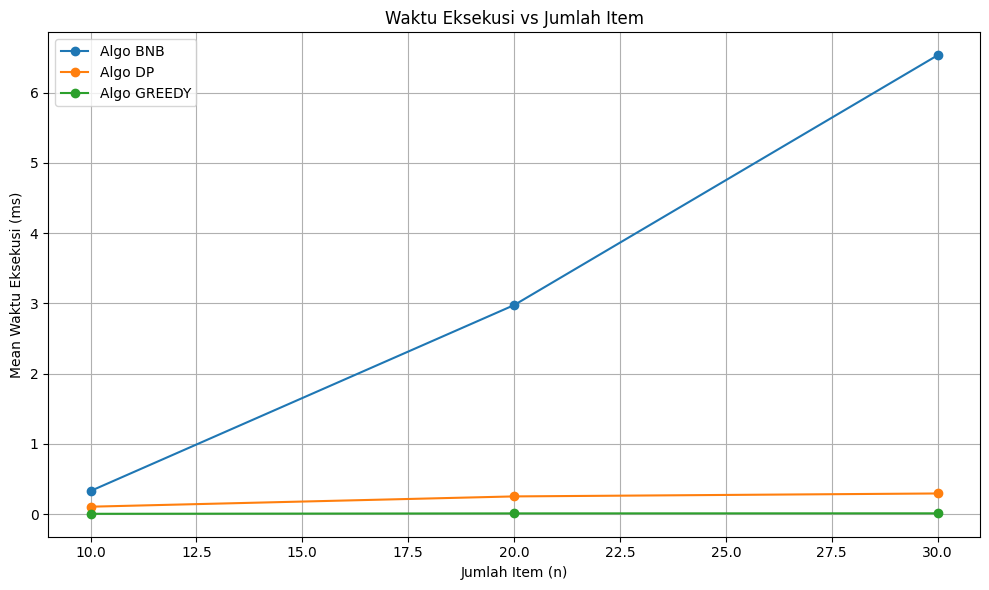

In [8]:
# Plot waktu eksekusi vs jumlah item
plt.figure(figsize=(10, 6))
for algo in sorted(df['algo'].unique()):
    xs = sorted(df['n'].unique())
    ys = [summary[(summary['algo'] == algo) & (summary['n'] == x)]['time_ms_mean'].values[0] for x in xs]
    plt.plot(xs, ys, marker='o', label=f'Algo {algo.upper()}')
plt.xlabel('Jumlah Item (n)')
plt.ylabel('Mean Waktu Eksekusi (ms)')
plt.title('Waktu Eksekusi vs Jumlah Item')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/plot_n_vs_time.png', dpi=150)
plt.show()

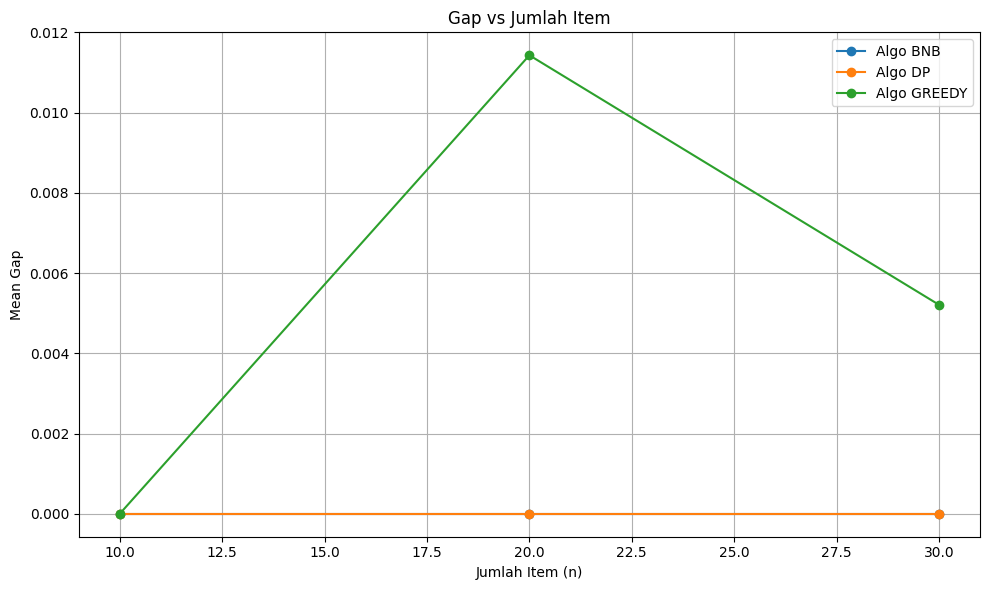

In [9]:
# Plot gap vs jumlah item
plt.figure(figsize=(10, 6))
for algo in sorted(df['algo'].unique()):
    xs = sorted(df['n'].unique())
    ys = [summary[(summary['algo'] == algo) & (summary['n'] == x)]['gap_mean'].values[0] for x in xs]
    plt.plot(xs, ys, marker='o', label=f'Algo {algo.upper()}')
plt.xlabel('Jumlah Item (n)')
plt.ylabel('Mean Gap')
plt.title('Gap vs Jumlah Item')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/plot_n_vs_gap.png', dpi=150)
plt.show()

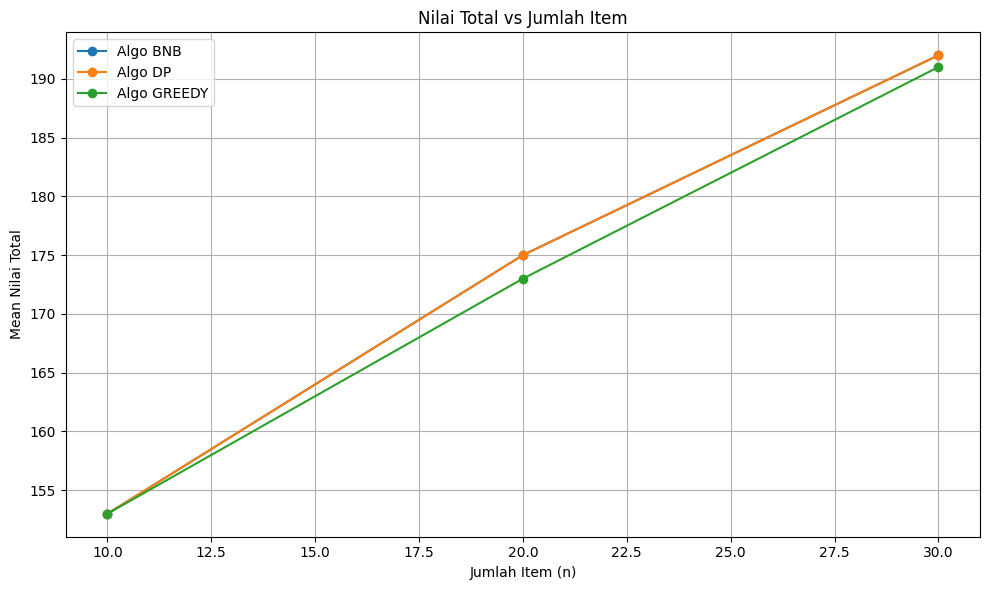

In [10]:
# Plot nilai vs jumlah item
plt.figure(figsize=(10, 6))
for algo in sorted(df['algo'].unique()):
    xs = sorted(df['n'].unique())
    ys = [summary[(summary['algo'] == algo) & (summary['n'] == x)]['value_mean'].values[0] for x in xs]
    plt.plot(xs, ys, marker='o', label=f'Algo {algo.upper()}')
plt.xlabel('Jumlah Item (n)')
plt.ylabel('Mean Nilai Total')
plt.title('Nilai Total vs Jumlah Item')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('results/plot_n_vs_value.png', dpi=150)
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_30512\3371574087.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


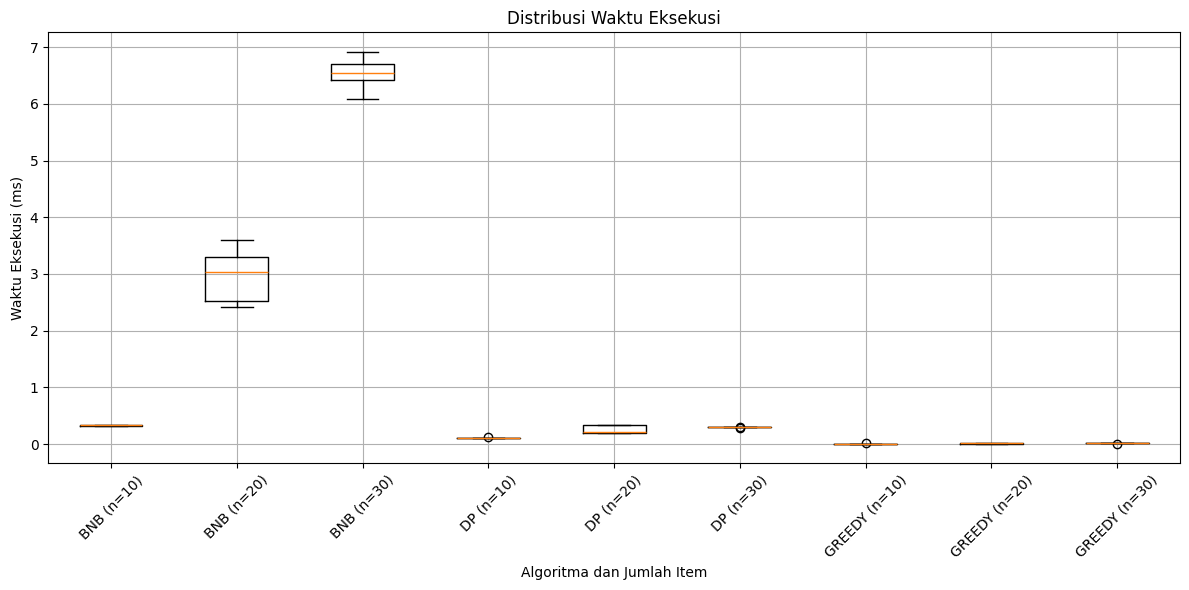

In [11]:
# Boxplot waktu eksekusi per algoritma
plt.figure(figsize=(12, 6))
data = []
labels = []
for algo in sorted(df['algo'].unique()):
    for n in sorted(df['n'].unique()):
        subset = df[(df['algo'] == algo) & (df['n'] == n)]['time_ms'].values
        data.append(subset)
        labels.append(f'{algo.upper()} (n={n})')
plt.boxplot(data, labels=labels)
plt.xlabel('Algoritma dan Jumlah Item')
plt.ylabel('Waktu Eksekusi (ms)')
plt.title('Distribusi Waktu Eksekusi')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('results/plot_box_time.png', dpi=150)
plt.show()

In [12]:
# Uji statistik (paired t-test)
try:
    from scipy.stats import ttest_rel
    print("\nUji Statistik (Paired t-test):")
    for n in sorted(df['n'].unique()):
        g = df[(df['n'] == n) & (df['algo'] == 'greedy')]['time_ms'].values
        d = df[(df['n'] == n) & (df['algo'] == 'dp')]['time_ms'].values
        b = df[(df['n'] == n) & (df['algo'] == 'bnb')]['time_ms'].values
        
        t_gd, p_gd = ttest_rel(g, d)
        t_gb, p_gb = ttest_rel(g, b)
        t_db, p_db = ttest_rel(d, b)
        
        print(f'n={n}:')
        print(f'  Greedy vs DP: t={t_gd:.3f}, p={p_gd:.4f}')
        print(f'  Greedy vs B&B: t={t_gb:.3f}, p={p_gb:.4f}')
        print(f'  DP vs B&B: t={t_db:.3f}, p={p_db:.4f}')
except Exception as e:
    print('SciPy tidak tersedia; lewati uji t berpasangan.', e)

# Ekspor tabel latex
latex_table = summary.rename(columns={
    'time_ms_mean': 'Mean (ms)', 
    'time_ms_sd': 'SD (ms)', 
    'gap_mean': 'Gap',
    'value_mean': 'Mean Value'
}).to_latex(index=False)

with open('results/summary.tex', 'w', encoding='utf-8') as f:
    f.write(latex_table)

print('\nTabel LaTeX disimpan di results/summary.tex')


Uji Statistik (Paired t-test):
n=10:
  Greedy vs DP: t=-49.359, p=0.0000
  Greedy vs B&B: t=-124.912, p=0.0000
  DP vs B&B: t=-65.069, p=0.0000
n=20:
  Greedy vs DP: t=-8.212, p=0.0012
  Greedy vs B&B: t=-13.088, p=0.0002
  DP vs B&B: t=-10.756, p=0.0004
n=30:
  Greedy vs DP: t=-193.630, p=0.0000
  Greedy vs B&B: t=-46.191, p=0.0000
  DP vs B&B: t=-44.217, p=0.0000

Tabel LaTeX disimpan di results/summary.tex


In [13]:
# Tampilkan solusi untuk instance penuh (30 item)
print("\nSolusi untuk Instance Penuh (30 item):")
full_instance = generate_instances(30, 42)

greedy_sol = greedy_knapsack(full_instance)
dp_sol = dp_knapsack(full_instance)
bnb_sol = branch_and_bound_knapsack(full_instance)

print(f"\nGreedy Solution:")
print(f"  Total Value: {greedy_sol['total_value']}")
print(f"  Total Weight: {greedy_sol['total_weight']}")
print(f"  Items: {[item['id'] for item in greedy_sol['items']]}")

print(f"\nDynamic Programming Solution:")
print(f"  Total Value: {dp_sol['total_value']}")
print(f"  Total Weight: {dp_sol['total_weight']}")
print(f"  Items: {[item['id'] for item in dp_sol['items']]}")

print(f"\nBranch and Bound Solution:")
print(f"  Total Value: {bnb_sol['total_value']}")
print(f"  Total Weight: {bnb_sol['total_weight']}")
print(f"  Items: {[item['id'] for item in bnb_sol['items']]}")

solutions = {'greedy': greedy_sol, 'dp': dp_sol, 'bnb': bnb_sol}
with open('results/solutions.json', 'w') as f:
    json.dump(solutions, f, indent=2)



Solusi untuk Instance Penuh (30 item):

Greedy Solution:
  Total Value: 191
  Total Weight: 49
  Items: ['LAB-A-021', 'LAB-A-029', 'LAB-A-011', 'LAB-A-025', 'LAB-A-018', 'LAB-A-006', 'LAB-A-014', 'LAB-A-002', 'LAB-A-008', 'LAB-A-004', 'LAB-A-001']

Dynamic Programming Solution:
  Total Value: 192
  Total Weight: 50
  Items: ['LAB-A-001', 'LAB-A-002', 'LAB-A-004', 'LAB-A-006', 'LAB-A-011', 'LAB-A-014', 'LAB-A-016', 'LAB-A-018', 'LAB-A-021', 'LAB-A-025', 'LAB-A-029']

Branch and Bound Solution:
  Total Value: 192
  Total Weight: 50
  Items: ['LAB-A-021', 'LAB-A-029', 'LAB-A-011', 'LAB-A-025', 'LAB-A-018', 'LAB-A-006', 'LAB-A-014', 'LAB-A-002', 'LAB-A-004', 'LAB-A-001', 'LAB-A-016']
